Données chargées et normalisées.

Exécution directe du DBSCAN avec eps=1.0 et min_samples=7...
Clusters trouvés: 290
Silhouette Score: -0.2501
Adjusted Rand Index (ARI): 0.0330

--- Métriques de Classification (Mapping) ---
Accuracy: 74.32%
              precision    recall  f1-score   support

           0       0.75      0.95      0.84     30942
           1       0.69      0.27      0.38     13261

    accuracy                           0.74     44203
   macro avg       0.72      0.61      0.61     44203
weighted avg       0.73      0.74      0.70     44203

Génération de la carte des clusters dans C:\Users\hp\Desktop\TPs\DataMining\Results\plots_clustering...


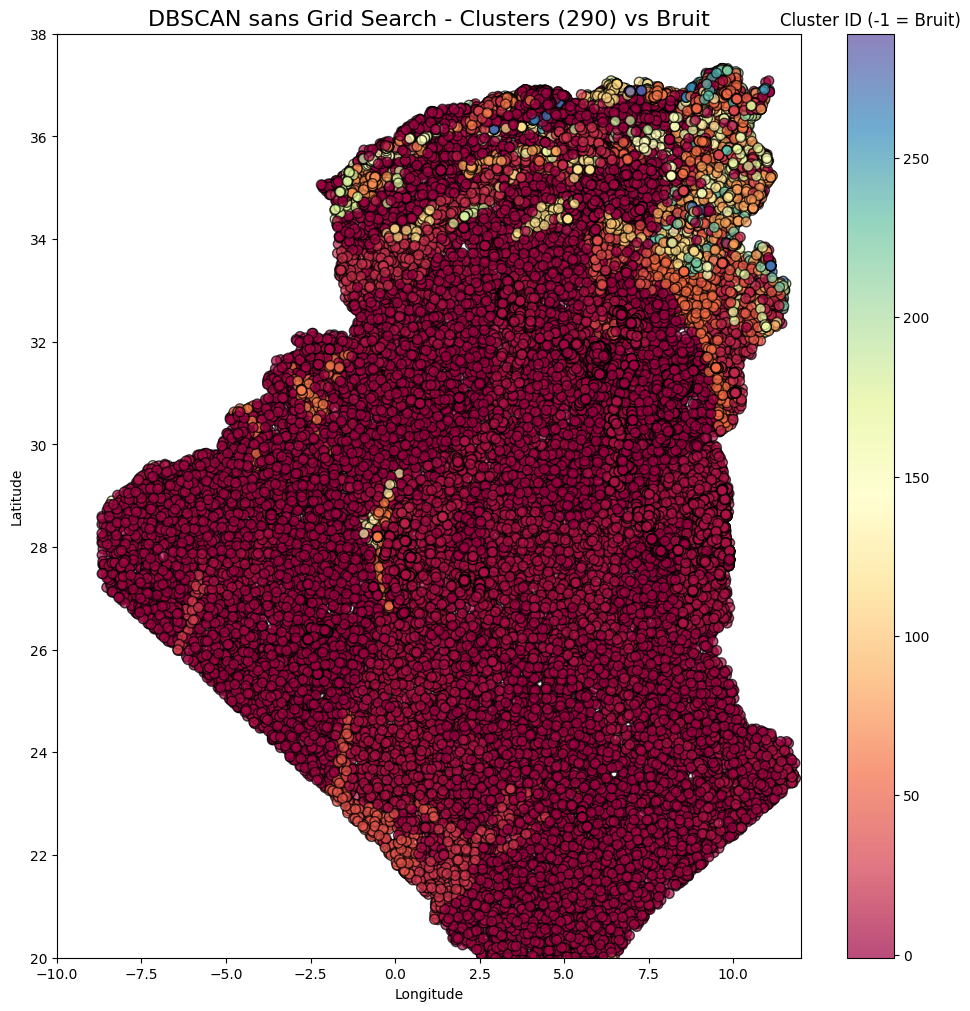

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score, accuracy_score, classification_report
from sklearn.neighbors import KDTree  # <-- Optimisation essentielle
from collections import Counter
import warnings

# Supprimer les warnings pour plus de lisibilité
warnings.filterwarnings('ignore') 

# --- CONFIGURATION ---
CHEMIN_FICHIER = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\preparing\\Final_Reduit30_70.csv'
COLONNE_CIBLE = 'classe'
DOSSIER_PLOTS = 'C:\\Users\\hp\\Desktop\\TPs\\DataMining\\Results\\plots_clustering'

if not os.path.exists(DOSSIER_PLOTS):
    os.makedirs(DOSSIER_PLOTS)

# --- Chargement et préparation des données ---
try:
    df = pd.read_csv(CHEMIN_FICHIER)
except FileNotFoundError:
    print(f"Erreur: Le fichier {CHEMIN_FICHIER} n'a pas été trouvé.")
    exit()

# Les colonnes 'latitude' et 'longitude' sont ignorées pour le clustering mais conservées dans df
X = df.drop(columns=[COLONNE_CIBLE, 'latitude', 'longitude'], errors='ignore')
y = df[COLONNE_CIBLE]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Données chargées et normalisées.")

# --- DBSCAN from scratch (OPTIMISÉ AVEC KD-TREE) ---
class DBSCANFromScratch:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.tree = None

    def fit(self, X):
        # Création de l'index spatial (KD-Tree) pour une recherche rapide des voisins
        self.tree = KDTree(X)
        
        n_samples = X.shape[0]
        labels = np.full(n_samples, -1)  # -1 = bruit
        cluster_id = 0
        visited = np.zeros(n_samples, dtype=bool)

        def region_query(point_idx):
            # Utiliser le KD-Tree pour trouver les indices en O(log N)
            indices = self.tree.query_radius(X[point_idx].reshape(1, -1), r=self.eps)
            return indices[0]

        def expand_cluster(point_idx, neighbors, cluster_id):
            labels[point_idx] = cluster_id
            i = 0
            while i < len(neighbors):
                n_idx = neighbors[i]
                n_idx = int(n_idx) 
                
                if not visited[n_idx]:
                    visited[n_idx] = True
                    n_neighbors = region_query(n_idx)
                    
                    if len(n_neighbors) >= self.min_samples:
                        # np.unique pour éviter les doublons inutiles
                        neighbors = np.unique(np.concatenate((neighbors, n_neighbors)))
                
                if labels[n_idx] == -1:
                    labels[n_idx] = cluster_id
                    
                i += 1

        for idx in range(n_samples):
            if visited[idx]:
                continue
            
            visited[idx] = True
            neighbors = region_query(idx)
            
            if len(neighbors) < self.min_samples:
                labels[idx] = -1
            else:
                # Point central trouvé: lancer l'expansion
                expand_cluster(idx, neighbors, cluster_id)
                cluster_id += 1

        self.labels_ = labels
        return self

# --- EXÉCUTION DIRECTE AVEC PARAMÈTRES FIXES ---
BEST_EPS = 1.0
BEST_MIN_SAMPLES = 7
best_params = {'eps': BEST_EPS, 'min_samples': BEST_MIN_SAMPLES}

print(f"\nExécution directe du DBSCAN avec eps={BEST_EPS} et min_samples={BEST_MIN_SAMPLES}...")

db = DBSCANFromScratch(eps=BEST_EPS, min_samples=BEST_MIN_SAMPLES)
db.fit(X_scaled)
best_labels = db.labels_

# --- Évaluation ---
n_clusters = len(set(best_labels)) - (1 if -1 in best_labels else 0)

if n_clusters >= 2:
    best_score = silhouette_score(X_scaled, best_labels)
    print(f"Clusters trouvés: {n_clusters}")
    print(f"Silhouette Score: {best_score:.4f}")
else:
    best_score = -1
    print(f"Attention: Seulement {n_clusters} cluster(s) trouvé(s). Le score Silhouette n'est pas applicable ou pertinent.")

# --- Evaluation supervisée et visualisation ---
if best_labels is not None:
    # 1. Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(y, best_labels)
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

    # 2. Mapping des clusters (non supervisé) vers les classes (supervisé)
    cluster_to_class = {}
    for c in np.unique(best_labels):
        if c == -1:
            continue
        mask = best_labels == c
        # Assigner la classe majoritaire du cluster à ce cluster
        majority_class = Counter(y[mask]).most_common(1)[0][0]
        cluster_to_class[c] = majority_class
        
    # Le bruit (-1) est mappé à 0 (pas feu)
    y_pred = np.array([cluster_to_class.get(label, 0) for label in best_labels]) 

    # 3. Métriques de classification
    print("\n--- Métriques de Classification (Mapping) ---")
    print(f"Accuracy: {accuracy_score(y, y_pred)*100:.2f}%")
    print(classification_report(y, y_pred, zero_division=0)) 

    # 4. Carte scatter map
    if 'latitude' in df.columns and 'longitude' in df.columns:
        print(f"Génération de la carte des clusters dans {DOSSIER_PLOTS}...")
        
        n_clusters_found = len(set(best_labels)) - (1 if -1 in best_labels else 0)
        
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_title(f'DBSCAN sans Grid Search - Clusters ({n_clusters_found}) vs Bruit', fontsize=16) 
        
        scatter = ax.scatter(
            df['longitude'], 
            df['latitude'], 
            c=best_labels, 
            cmap='Spectral', 
            s=50, 
            alpha=0.7, 
            edgecolor='k'
        )
        
        cbar = fig.colorbar(scatter)
        cbar.ax.set_title('Cluster ID (-1 = Bruit)')
        
        # Référence aux limites de l'ancien script
        ax.set_xlim([-10, 12]) 
        ax.set_ylim([20, 38])
        
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.savefig(os.path.join(DOSSIER_PLOTS, 'dbscan_fixed_params_map.png'), dpi=300)
        plt.show()